In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
data_df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

In [5]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,...,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

In [ ]:
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

In [10]:
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


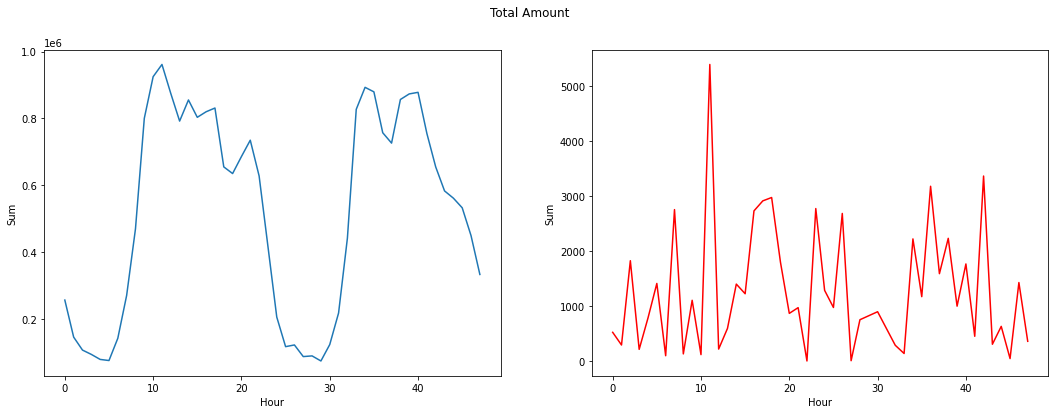

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

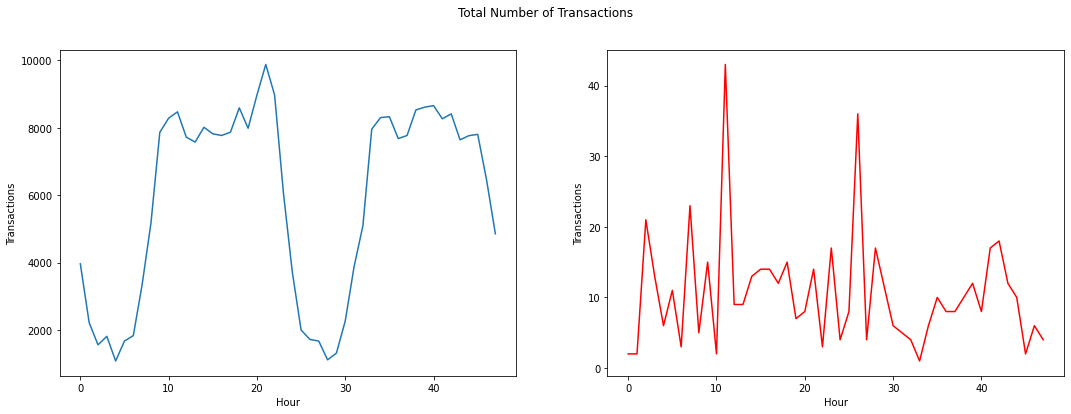

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

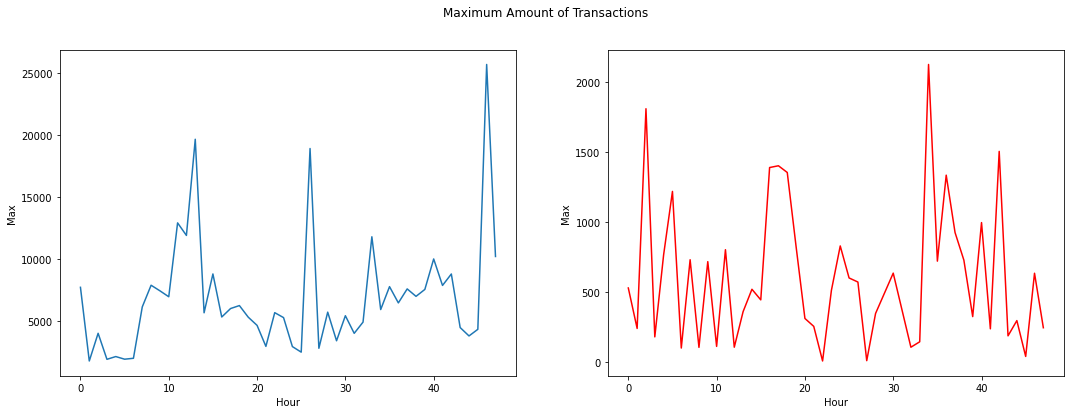

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

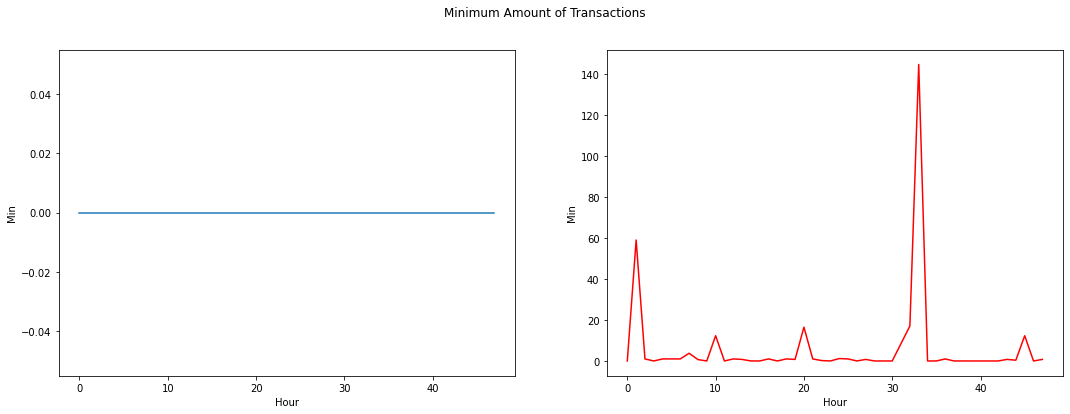

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

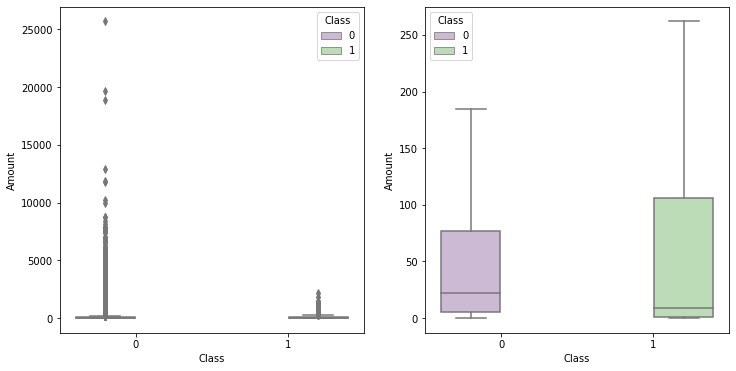

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [16]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [17]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [ ]:
fraud = data_df.loc[data_df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

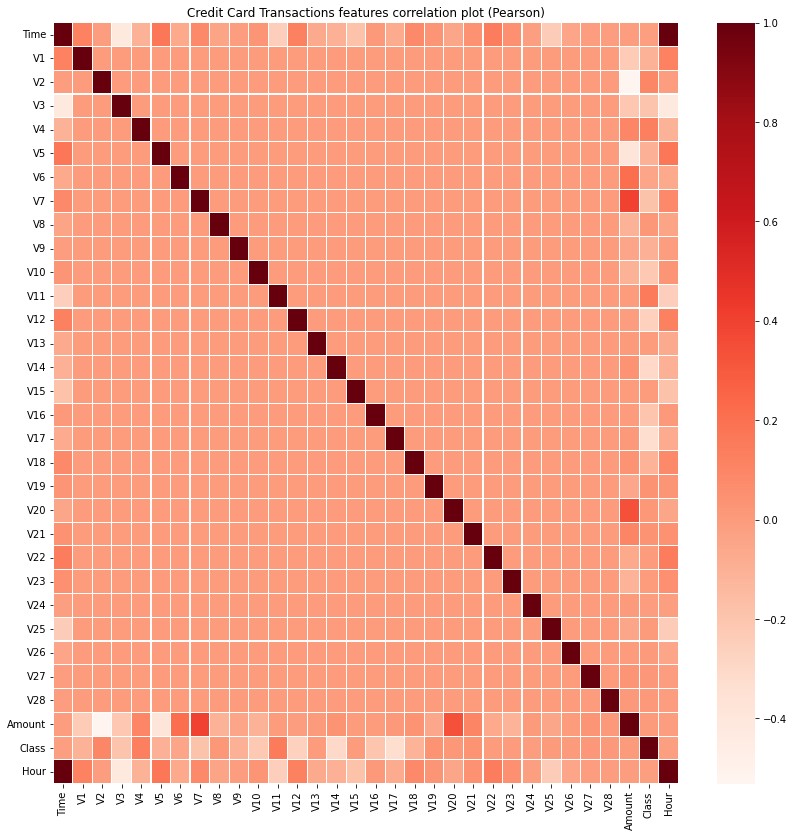

In [19]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

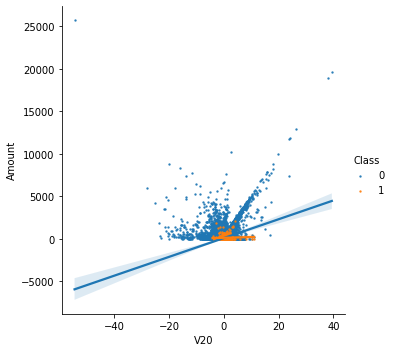

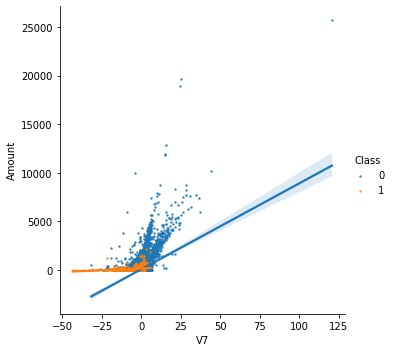

In [22]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

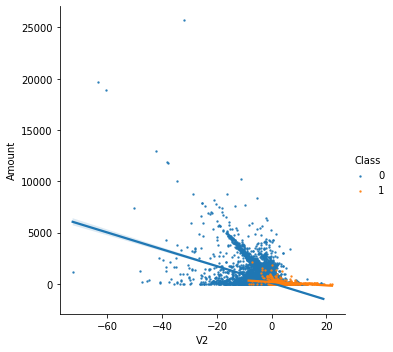

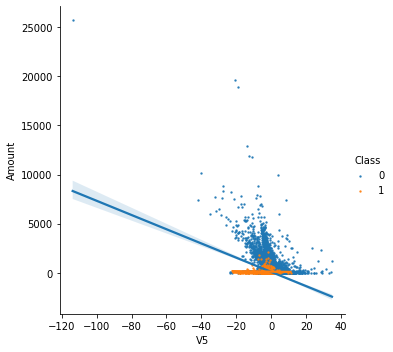

In [23]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

In [25]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [28]:
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

XGBOOST

In [29]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [30]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.889519	valid-auc:0.852739
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.939441	valid-auc:0.881959
[100]	train-auc:0.944161	valid-auc:0.890967
[150]	train-auc:0.977186	valid-auc:0.964228
[200]	train-auc:0.990128	valid-auc:0.982695
[250]	train-auc:0.994442	valid-auc:0.986025
[300]	train-auc:0.996408	valid-auc:0.984589
Stopping. Best iteration:
[258]	train-auc:0.995034	valid-auc:0.986645



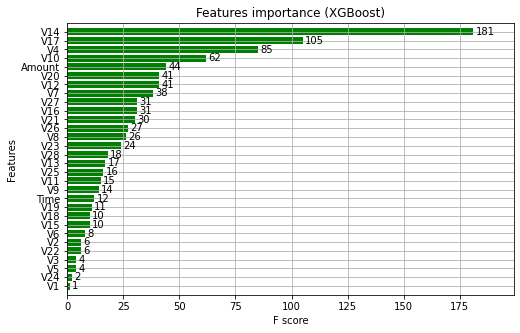

In [31]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

In [32]:
preds = model.predict(dtest)

In [33]:
roc_auc_score(test_df[target].values, preds)

0.9770317611058352

LightBGM

In [34]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

In [35]:
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

In [36]:
evals_results = {}

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=2*EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)

Training until validation scores don't improve for 100 rounds.
[50]	train's auc: 0.97289	valid's auc: 0.967126
[100]	train's auc: 0.987513	valid's auc: 0.972525
[150]	train's auc: 0.988872	valid's auc: 0.93531
Early stopping, best iteration is:
[85]	train's auc: 0.987093	valid's auc: 0.974528


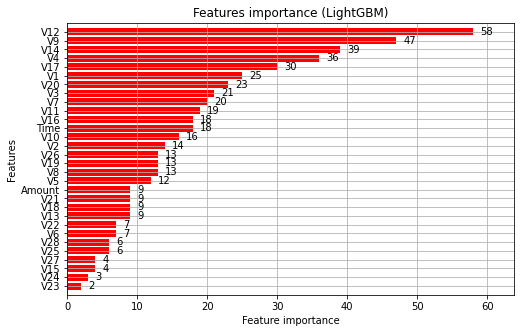

In [37]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

In [38]:
preds = model.predict(test_df[predictors])

In [39]:
roc_auc_score(test_df[target].values, preds)

0.9459470296507333

ADA BOOST Classifier

In [41]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [43]:
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [44]:
preds = clf.predict(valid_df[predictors])

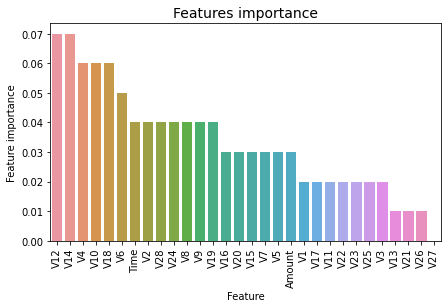

In [45]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

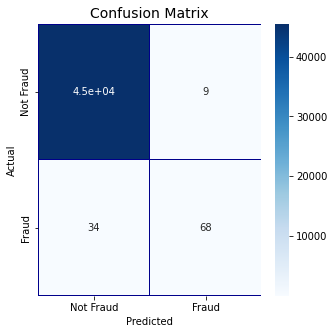

In [46]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()